# 4: NPV Score 

### Import relevant packages 

In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

### NPV_kaufen, NPV_mieten_und_investieren, NPV_delta, Score

In [2]:
def annuitaet_zahlung(kreditsumme: float, zins: float, tilgung: float) -> float:

    if kreditsumme <= 0:
        return 0.0
    if zins < 0 or tilgung < 0:
        raise ValueError("Zins und Tilgung müssen > 0 sein")

    return kreditsumme * (zins + tilgung)

def npv_kaufen(kaufpreis_pro_m2: float, zins: float, erwartete_rendite: float, tilgung: float, betrachtungszeitraum: int = 10, 
               wohnflaeche_m2: float = 80.0, eigenkapitalquote: float = 0.20, kaufnebenkosten_quote: float = 0.10, 
               verkaufskosten_quote: float = 0.05, instandhaltung_quote: float = 0.01, preissteigerung_immobilie: float = 0.02,
               steuersatz_veraeusserungsgewinn: float = 0.25) -> float:
    
    H = int(betrachtungszeitraum)
    if H <= 0:
        return np.nan

    # Initialwerte
    kaufpreis = float(kaufpreis_pro_m2) * float(wohnflaeche_m2)
    kaufnebenkosten = kaufpreis * kaufnebenkosten_quote
    anschaffungskosten = kaufpreis + kaufnebenkosten
    eigenkapital = eigenkapitalquote * anschaffungskosten
    darlehen = anschaffungskosten - eigenkapital
    annuitaet = annuitaet_zahlung(darlehen, zins, tilgung)
    restschuld = darlehen

    # CF Betrachtung    
    cashflows = np.zeros(H + 1)
    # CF0
    cashflows[0] = -eigenkapital
    # CF1 bis CFH+1
    for t in range(1, H + 1):
        immowert_t = kaufpreis * (1.0 + preissteigerung_immobilie) ** t
        zinsen_t = restschuld * zins
        tilgung_t = max(0.0, annuitaet - zinsen_t)
        tilgung_t = min(tilgung_t, restschuld)
        restschuld = max(0.0, restschuld - tilgung_t)
        instandhaltung_t = instandhaltung_quote * immowert_t
        cashflows[t] = -(zinsen_t + tilgung_t) - instandhaltung_t

    # CFH: CF bei Verkauf
    immowert_H = kaufpreis * (1.0 + preissteigerung_immobilie) ** H
    verkaufserloes_netto = immowert_H * (1.0 - verkaufskosten_quote)
    veraeusserungsgewinn = verkaufserloes_netto - anschaffungskosten

    steuer = 0.0
    if H < 10:
        steuer = max(0.0, veraeusserungsgewinn) * steuersatz_veraeusserungsgewinn

    cashflows[H] += (verkaufserloes_netto - steuer - restschuld)

    # Discounting Cash Flows
    diskontfaktoren = np.array([(1.0 + erwartete_rendite) ** t for t in range(H + 1)])
    kapitalwert = float(np.sum(cashflows / diskontfaktoren))
    return kapitalwert

def npv_mieten_und_investieren(mietpreis_pro_m2: float, rendite_invest: float, erwartete_rendite: float, betrachtungszeitraum: int = 10, 
                               wohnflaeche_m2: float = 80.0, mietsteigerung: float = 0.02, 
                               # Buy Parameter: 
                               kaufpreis_pro_m2: float = 0.0, zins: float = 0.0, tilgung: float = 0.0, eigenkapitalquote: float = 0.20, 
                               kaufnebenkosten_quote: float = 0.10, instandhaltung_quote: float = 0.01, 
                               preissteigerung_immobilie: float = 0.02,
                               # Steuer (Endbesteuerung auf Gewinn)
                               kapitalertragssteuer_satz: float = 0.26375,) -> float:
    
    H = int(betrachtungszeitraum)
    if H <= 0:
        return np.nan

    # Budget = Annuität + Instandhaltungskosten 
    kaufpreis = float(kaufpreis_pro_m2) * float(wohnflaeche_m2)
    kaufnebenkosten = kaufpreis * kaufnebenkosten_quote
    anschaffungskosten = kaufpreis + kaufnebenkosten
    eigenkapital = eigenkapitalquote * anschaffungskosten
    darlehen = anschaffungskosten - eigenkapital
    annuitaet = annuitaet_zahlung(darlehen, zins, tilgung)

    # Initialmiete
    jahresmiete_0 = float(mietpreis_pro_m2) * float(wohnflaeche_m2) * 12.0

    # Initial-Investieren 
    vermoegen = float(eigenkapital)
    eingezahltes_geld = float(eigenkapital) # Summe der Einzahlungen ins Depot 

    # CF Betrachtung
    cashflows = np.zeros(H + 1, dtype=float)
    # CF0
    cashflows[0] = -float(eigenkapital)
    # CF1 bis CFH+1
    for t in range(1, H + 1):
        # budget_t = Annuität + Instandhaltungskosten
        immowert_t = kaufpreis * (1.0 + preissteigerung_immobilie) ** t
        instandhaltung_t = instandhaltung_quote * immowert_t
        budget_t = annuitaet + instandhaltung_t
        # Mietkosten + (Differenz) Investieren
        miete_t = jahresmiete_0 * (1.0 + mietsteigerung) ** (t - 1)
        sparen_t = budget_t - miete_t
        # Portfolioentwicklung
        vermoegen = vermoegen * (1.0 + rendite_invest) + sparen_t
        if sparen_t > 0:
            eingezahltes_geld += sparen_t

        # Budget als negativen Cashoutflow
        cashflows[t] = -budget_t

    # CFH: CF bei Verkauf
    gewinn = max(0.0, vermoegen - eingezahltes_geld)
    steuer = gewinn * float(kapitalertragssteuer_satz)
    vermoegen_netto = vermoegen - steuer

    cashflows[H] += vermoegen_netto
    # Discounting Cash Flows 
    diskontfaktoren = np.array([(1.0 + float(erwartete_rendite)) ** t for t in range(H + 1)], dtype=float)
    kapitalwert = float(np.sum(cashflows / diskontfaktoren))
    return kapitalwert


def npv_delta(kaufpreis_pro_m2: float, mietpreis_pro_m2: float, zins: float, tilgung: float, diskontsatz: float, rendite_invest: float,
    betrachtungszeitraum: int = 10, wohnflaeche_m2: float = 58.0, mietsteigerung: float = 0.02, kaufnebenkosten_quote: float = 0.10,
    eigenkapitalquote: float = 0.14, preissteigerung_immobilie: float = 0.03, instandhaltung_quote: float = 0.005,
    verkaufskosten_quote: float = 0.00, steuersatz_veraeusserungsgewinn: float = 0.25,) -> float:
   
    npv_buy = npv_kaufen(kaufpreis_pro_m2=kaufpreis_pro_m2, zins=zins, tilgung=tilgung, erwartete_rendite=diskontsatz, 
                         betrachtungszeitraum=betrachtungszeitraum, wohnflaeche_m2=wohnflaeche_m2, 
                         kaufnebenkosten_quote=kaufnebenkosten_quote, eigenkapitalquote=eigenkapitalquote,
                         preissteigerung_immobilie=preissteigerung_immobilie, instandhaltung_quote=instandhaltung_quote, 
                         verkaufskosten_quote=verkaufskosten_quote, steuersatz_veraeusserungsgewinn=steuersatz_veraeusserungsgewinn,)

    npv_rent_inv = npv_mieten_und_investieren(mietpreis_pro_m2=mietpreis_pro_m2, rendite_invest=rendite_invest, 
                                              erwartete_rendite=diskontsatz, betrachtungszeitraum=betrachtungszeitraum, 
                                              wohnflaeche_m2=wohnflaeche_m2, mietsteigerung=mietsteigerung, 
                                              kaufpreis_pro_m2=kaufpreis_pro_m2, zins=zins, tilgung=tilgung, 
                                              eigenkapitalquote=eigenkapitalquote, kaufnebenkosten_quote=kaufnebenkosten_quote, 
                                              instandhaltung_quote=instandhaltung_quote, 
                                              preissteigerung_immobilie=preissteigerung_immobilie,)

    delta = npv_buy - npv_rent_inv
    return delta

def rent_vs_buy_score(delta_npv: float, scale: float) -> float:

    if scale <= 0:
        raise ValueError("scale must be positive")
    return float(np.tanh(delta_npv / scale))

In [3]:
BASE_DIR = Path("..") / "data" / "output"

df_empirica_regio = pd.read_csv(
    BASE_DIR / "empirica_regio_data.csv",
    encoding="utf-8-sig",
)
df_empirica_regio["Jahr"] = df_empirica_regio["Jahr"].astype(int)

df_macroeconomic_y = pd.read_csv(
    BASE_DIR / "macroeconomic_data_yearly.csv", 
    encoding="utf-8-sig",
)
df_macroeconomic_y["Jahr"] = df_macroeconomic_y["Jahr"].astype(int)

# df_empirica_regio = df_empirica_regio[df_empirica_regio["Regionsebene"] == "Gemeinde"]

df_empirica_regio = df_empirica_regio.merge(df_macroeconomic_y, on=["Jahr"], how="left")

In [4]:
df_empirica_regio

,Regionsebene,RegionID,Regionsname,Jahr,Kaufpreis/m2 ETW 5%,Kaufpreis/m2 ETW 50%,Kaufpreis/m2 ETW 95%,Kaufpreis/m2 EZFH 5%,Kaufpreis/m2 EZFH 50%,Kaufpreis/m2 EZFH 95%,...,Inflation,Einlagefazilität,Hauptrefinanzierungsgeschäft,ifo Geschäftserwartung (Deutschland),ifo Geschäftsklima (Deutschland),ifo Geschäftsklima (Vearbeitendes Gewerbe),ifo Geschäftsklima (Bauhauptgewerbe),CCI,10 Jahre Sollzinsbindung,15 Jahre Sollzinsbindung
0,Kreisfreie Stadt,1001,Flensburg,2004,536.0,825.0,2175.0,NaN,NaN,NaN,...,0.0166,0.0100,0.0200,NaN,NaN,7.8000,-41.6833,-17.4750,NaN,NaN
1,Kreisfreie Stadt,1001,Flensburg,2005,533.0,819.0,2160.0,NaN,NaN,NaN,...,0.0154,0.0102,0.0202,2.5833,0.9750,4.4167,-37.7583,-14.2000,NaN,NaN
2,Kreisfreie Stadt,1001,Flensburg,2006,528.0,812.0,2141.0,NaN,NaN,NaN,...,0.0159,0.0169,0.0269,12.1667,16.1583,21.0667,-16.6000,-8.4083,NaN,NaN
3,Kreisfreie Stadt,1001,Flensburg,2007,538.0,828.0,2183.0,NaN,NaN,NaN,...,0.0231,0.0281,0.0381,11.4250,18.7667,25.6417,-15.7667,-4.5417,NaN,NaN
4,Kreisfreie Stadt,1001,Flensburg,2008,553.0,851.0,2242.0,NaN,NaN,NaN,...,0.0263,0.0296,0.0388,-8.9167,2.4333,0.5667,-22.9917,-13.4333,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8795,Landkreis,16077,Altenburger Land,2021,385.0,985.0,1561.0,261.0,1052.0,2402.0,...,0.0307,-0.0050,0.0000,4.4333,12.5667,21.2417,5.0333,-5.1917,0.0090,0.0118
8796,Landkreis,16077,Altenburger Land,2022,501.0,1039.0,1905.0,386.0,1361.0,2973.0,...,0.0687,0.0006,0.0056,-22.7250,-2.3417,-1.3583,-13.2333,-19.8500,0.0264,0.0286
8797,Landkreis,16077,Altenburger Land,2023,496.0,937.0,1666.0,300.0,1113.0,2788.0,...,0.0600,0.0327,0.0377,-19.8750,-5.7000,-7.7083,-24.4250,-15.2250,0.0388,0.0401
8798,Landkreis,16077,Altenburger Land,2024,498.0,1200.0,4830.0,348.0,1063.0,2823.0,...,0.0225,0.0377,0.0418,-17.8000,-10.3167,-15.8583,-28.5667,-11.1917,0.0349,0.0360


In [5]:
df_empirica_regio["Delta_NPV_5%"] = df_empirica_regio.apply(
    lambda row: npv_delta(kaufpreis_pro_m2=row["Kaufpreis/m2 ETW 5%"], mietpreis_pro_m2=row["Mietpreis/m2 5%"], zins=row["Effektiver Jahreszins"], 
                          tilgung=0.02, diskontsatz=0.04, rendite_invest=0.08, betrachtungszeitraum=10, wohnflaeche_m2=58,
                          mietsteigerung=0.02, kaufnebenkosten_quote=0.1, eigenkapitalquote=0.14, 
                          preissteigerung_immobilie=0.02, instandhaltung_quote=0.005, verkaufskosten_quote=0, 
                          steuersatz_veraeusserungsgewinn=0.25),
    axis=1
)
df_empirica_regio["Delta_NPV_50%"] = df_empirica_regio.apply(
    lambda row: npv_delta(kaufpreis_pro_m2=row["Kaufpreis/m2 ETW 50%"], mietpreis_pro_m2=row["Mietpreis/m2 50%"], zins=row["Effektiver Jahreszins"], 
                          tilgung=0.02, diskontsatz=0.04, rendite_invest=0.08, betrachtungszeitraum=10, wohnflaeche_m2=58,
                          mietsteigerung=0.02, kaufnebenkosten_quote=0.1, eigenkapitalquote=0.14, 
                          preissteigerung_immobilie=0.02, instandhaltung_quote=0.005, verkaufskosten_quote=0, 
                          steuersatz_veraeusserungsgewinn=0.25),
    axis=1
)
df_empirica_regio["Delta_NPV_95%"] = df_empirica_regio.apply(
    lambda row: npv_delta(kaufpreis_pro_m2=row["Kaufpreis/m2 ETW 95%"], mietpreis_pro_m2=row["Mietpreis/m2 95%"], zins=row["Effektiver Jahreszins"], 
                          tilgung=0.02, diskontsatz=0.04, rendite_invest=0.08, betrachtungszeitraum=10, wohnflaeche_m2=58,
                          mietsteigerung=0.02, kaufnebenkosten_quote=0.1, eigenkapitalquote=0.14, 
                          preissteigerung_immobilie=0.02, instandhaltung_quote=0.005, verkaufskosten_quote=0, 
                          steuersatz_veraeusserungsgewinn=0.25),
    axis=1
)


df_empirica_regio = df_empirica_regio[["Regionsname", "RegionID", "Jahr", "Kaufpreis/m2 ETW 5%", "Mietpreis/m2 5%", "Kaufpreis/m2 ETW 50%", "Mietpreis/m2 50%", "Kaufpreis/m2 ETW 95%", "Mietpreis/m2 95%", "Wohneigentumsquote", "Effektiver Jahreszins", "Delta_NPV_5%", "Delta_NPV_50%", "Delta_NPV_95%"]]
df_empirica_regio["Delta_NPV_5%_rel"] = df_empirica_regio["Delta_NPV_5%"] / (df_empirica_regio["Kaufpreis/m2 ETW 5%"] * 58 * (1.0 + 0.1))
df_empirica_regio["Delta_NPV_50%_rel"] = df_empirica_regio["Delta_NPV_50%"] / (df_empirica_regio["Kaufpreis/m2 ETW 50%"] * 58 * (1.0 + 0.1))
df_empirica_regio["Delta_NPV_95%_rel"] = df_empirica_regio["Delta_NPV_95%"] / (df_empirica_regio["Kaufpreis/m2 ETW 95%"] * 58 * (1.0 + 0.1))

# choose 5% NPV advantage as 0.5 Score
S = 0.05 / np.arctanh(0.5)
df_empirica_regio["Score (5% Perzentil)"] = np.tanh(df_empirica_regio["Delta_NPV_5%_rel"] / S)
df_empirica_regio["Score (50% Perzentil)"] = np.tanh(df_empirica_regio["Delta_NPV_50%_rel"] / S)
df_empirica_regio["Score (95% Perzentil)"] = np.tanh(df_empirica_regio["Delta_NPV_95%_rel"] / S)

C:\Users\49176\AppData\Local\Temp\ipykernel_1340\171668231.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_empirica_regio["Delta_NPV_5%_rel"] = df_empirica_regio["Delta_NPV_5%"] / (df_empirica_regio["Kaufpreis/m2 ETW 5%"] * 58 * (1.0 + 0.1))
C:\Users\49176\AppData\Local\Temp\ipykernel_1340\171668231.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_empirica_regio["Delta_NPV_50%_rel"] = df_empirica_regio["Delta_NPV_50%"] / (df_empirica_regio["Kaufpreis/m2 ETW 50%"] * 58 * (1.0 + 0.1))
C:\Users\

In [6]:
export = df_empirica_regio[
    [
        "Regionsname",
        "RegionID",
        "Jahr",
        "Score (5% Perzentil)",
        "Score (50% Perzentil)",
        "Score (95% Perzentil)"
    ]
]

from pathlib import Path

out_path = Path("..") / "data" / "output" / "export_3_level_Score.csv"
export.to_csv(out_path, sep=";", decimal=",", index=False, encoding="utf-8-sig")


In [7]:
df_empirica_regio

,Regionsname,RegionID,Jahr,Kaufpreis/m2 ETW 5%,Mietpreis/m2 5%,Kaufpreis/m2 ETW 50%,Mietpreis/m2 50%,Kaufpreis/m2 ETW 95%,Mietpreis/m2 95%,Wohneigentumsquote,Effektiver Jahreszins,Delta_NPV_5%,Delta_NPV_50%,Delta_NPV_95%,Delta_NPV_5%_rel,Delta_NPV_50%_rel,Delta_NPV_95%_rel,Score (5% Perzentil),Score (50% Perzentil),Score (95% Perzentil)
0,Flensburg,1001,2004,536.0,3.04,825.0,3.90,2175.0,5.30,NaN,0.0483,5464.186565,3513.643253,-24518.403449,0.159786,0.066755,-0.176690,0.941991,0.625127,-0.959624
1,Flensburg,1001,2005,533.0,3.00,819.0,3.85,2160.0,5.24,27.8,0.0434,6241.544091,5136.829652,-19739.876989,0.183546,0.098308,-0.143242,0.965172,0.793209,-0.917608
2,Flensburg,1001,2006,528.0,3.15,812.0,4.04,2141.0,5.49,27.8,0.0469,6496.864621,5313.728353,-20935.691209,0.192863,0.102571,-0.153267,0.971528,0.809939,-0.933355
3,Flensburg,1001,2007,538.0,3.18,828.0,4.07,2183.0,5.54,27.7,0.0515,5575.120746,3391.736564,-26254.129792,0.162424,0.064205,-0.188505,0.945168,0.607764,-0.968711
4,Flensburg,1001,2008,553.0,3.23,851.0,4.14,2242.0,5.63,27.7,0.0527,5258.469939,2735.371723,-28576.985135,0.149044,0.050381,-0.199784,0.927110,0.503132,-0.975495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8795,Altenburger Land,16077,2021,385.0,4.22,985.0,5.33,1561.0,6.88,37.3,0.0130,25186.018093,24170.859025,26764.303551,1.025364,0.384623,0.268740,1.000000,0.999573,0.994562
8796,Altenburger Land,16077,2022,501.0,4.43,1039.0,5.45,1905.0,7.00,37.4,0.0257,21774.641620,17630.146988,13835.426236,0.681228,0.265962,0.113835,0.999999,0.994221,0.848454
8797,Altenburger Land,16077,2023,496.0,4.55,937.0,5.59,1666.0,7.39,37.4,0.0406,19092.658235,13930.519406,9582.581519,0.603343,0.233027,0.090154,0.999997,0.988121,0.757553
8798,Altenburger Land,16077,2024,498.0,4.81,1200.0,5.88,4830.0,7.49,37.5,0.0384,21492.821359,11409.485141,-61898.288177,0.676462,0.149027,-0.200868,0.999999,0.927084,-0.976065


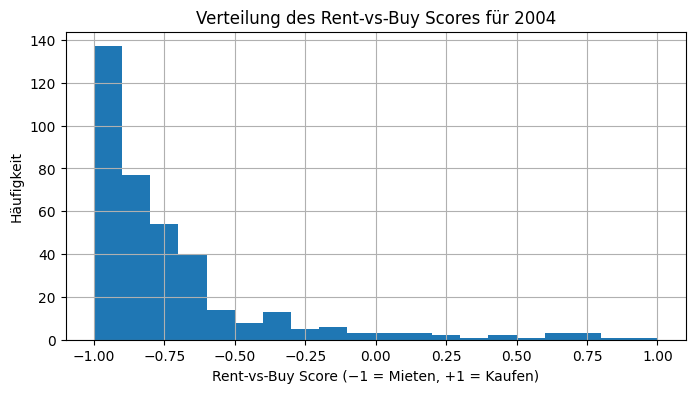

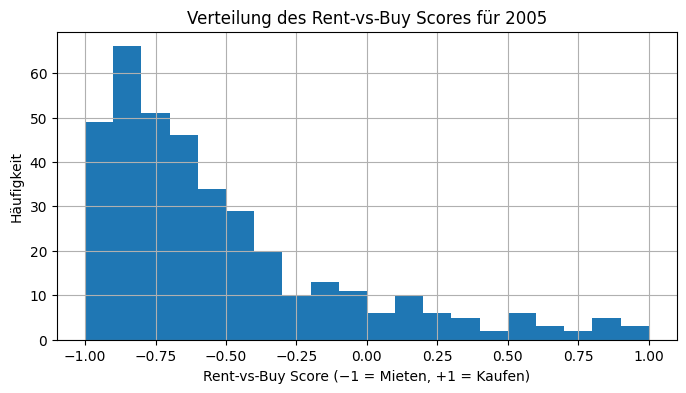

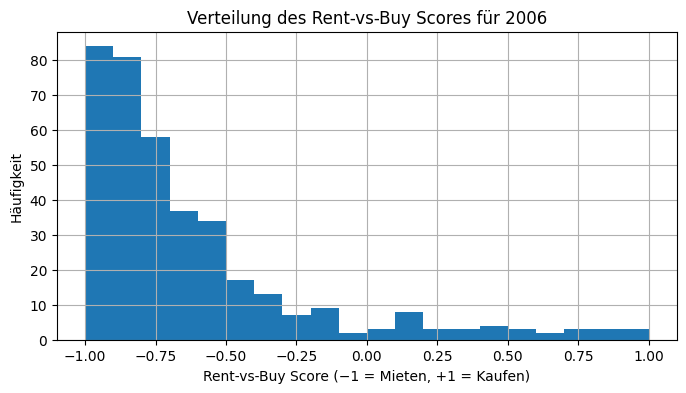

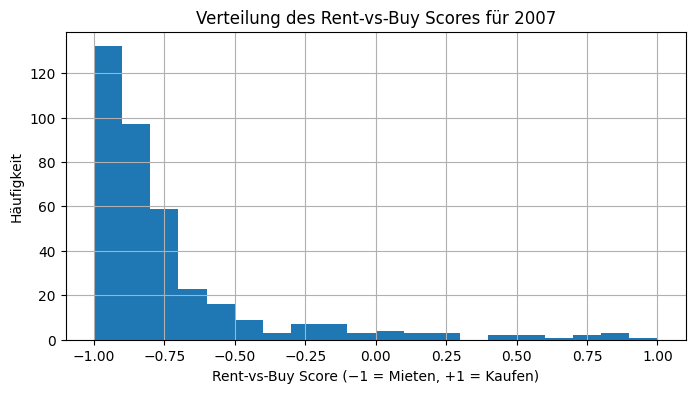

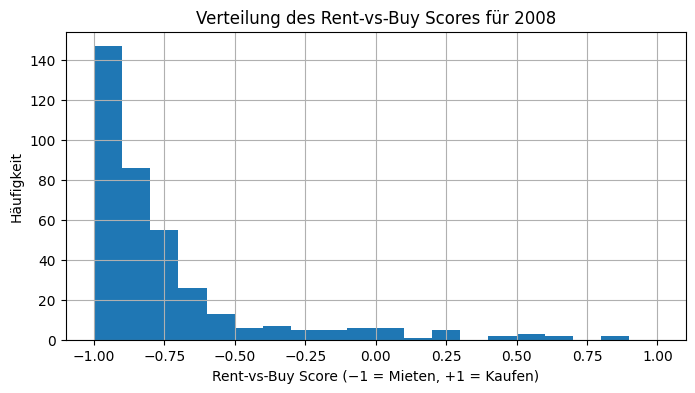

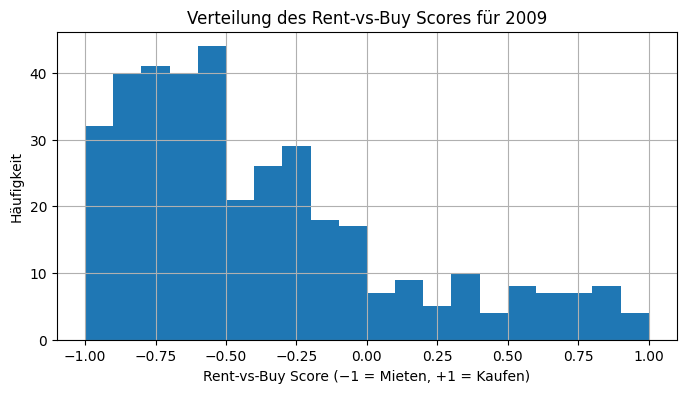

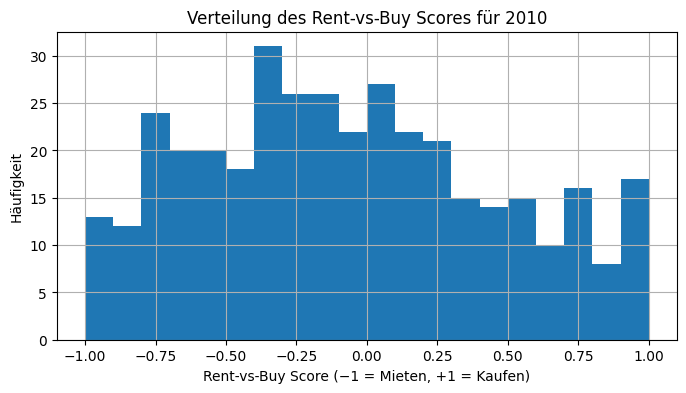

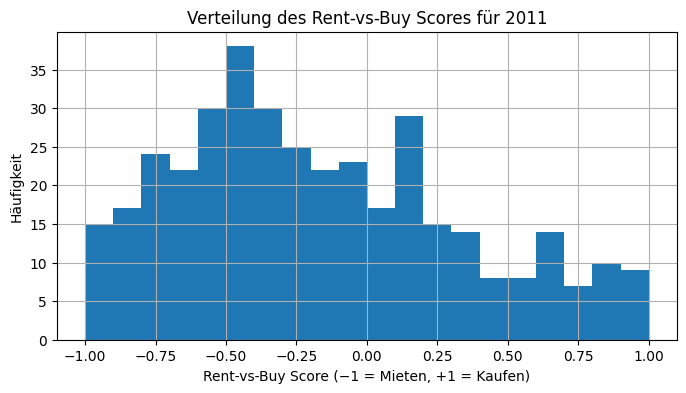

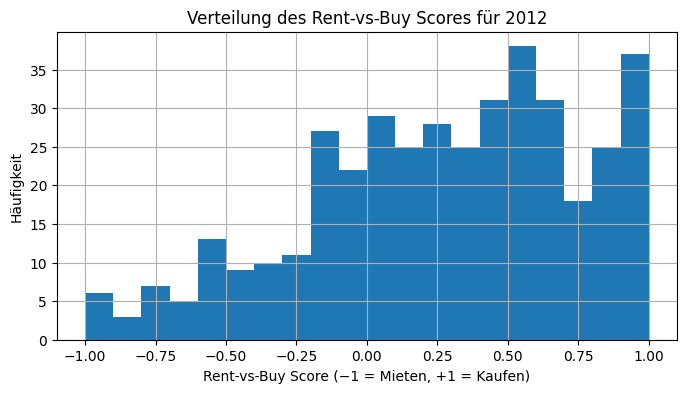

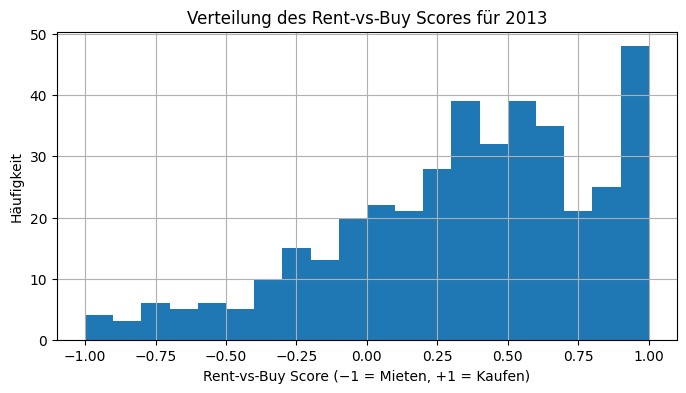

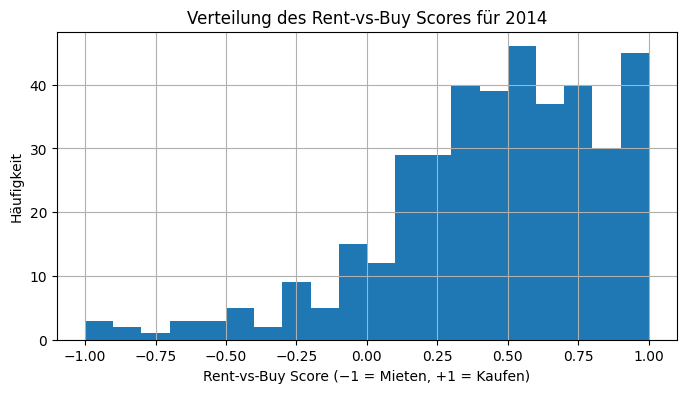

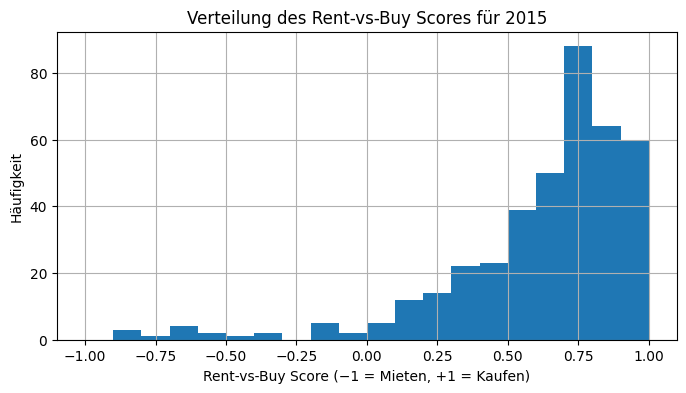

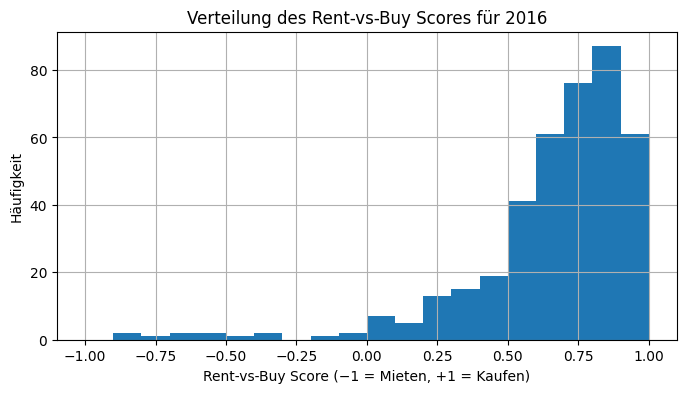

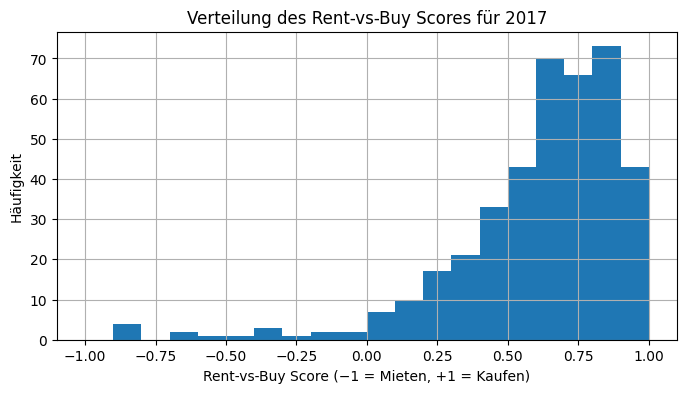

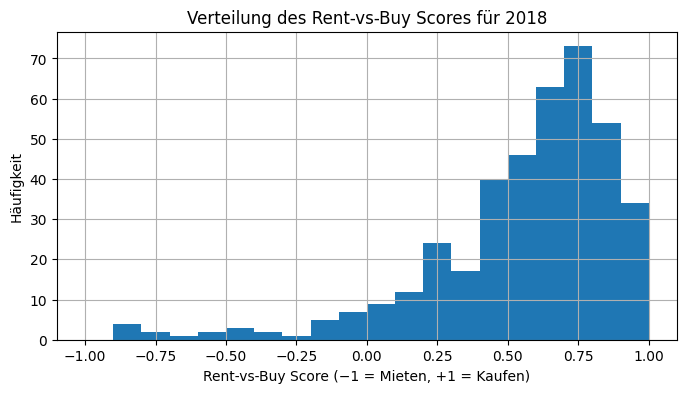

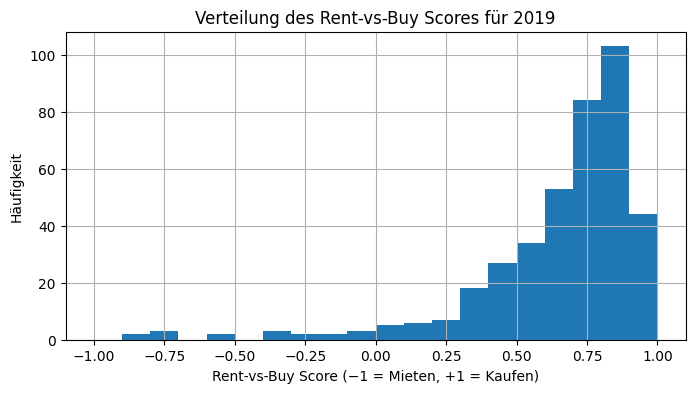

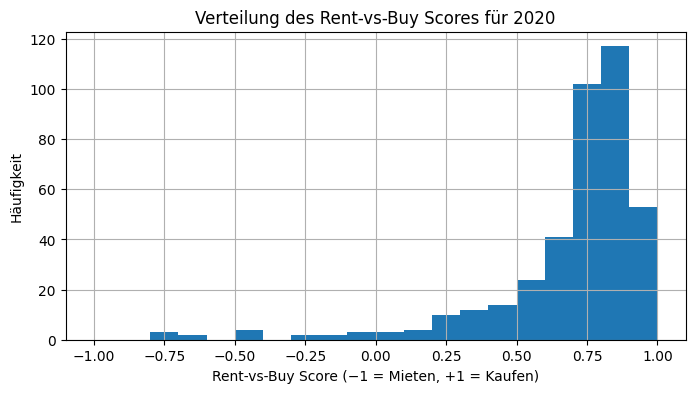

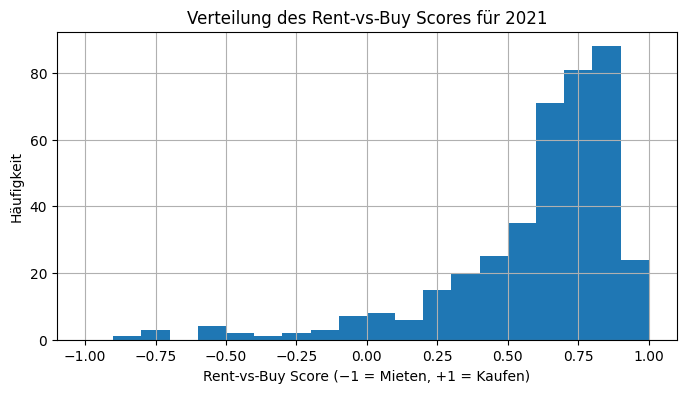

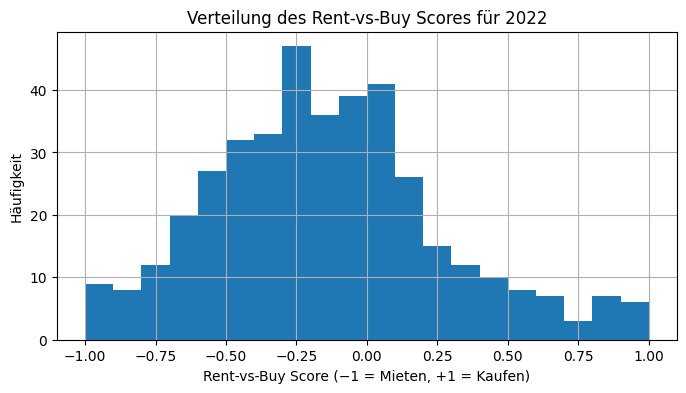

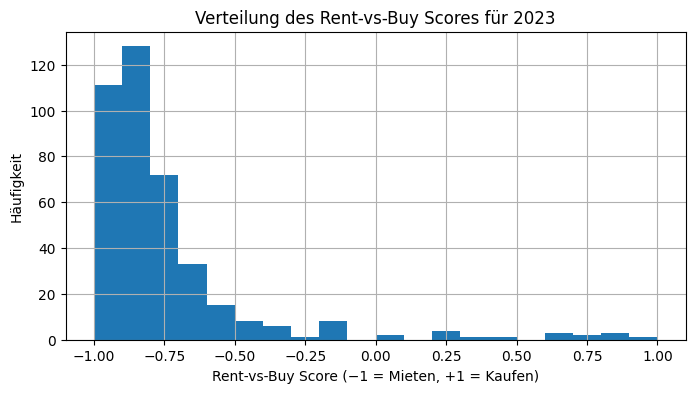

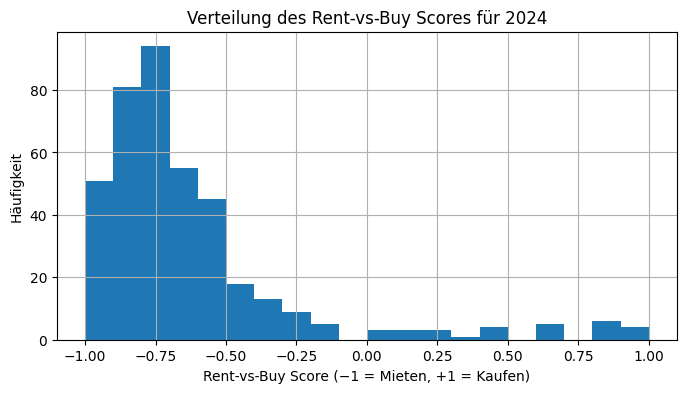

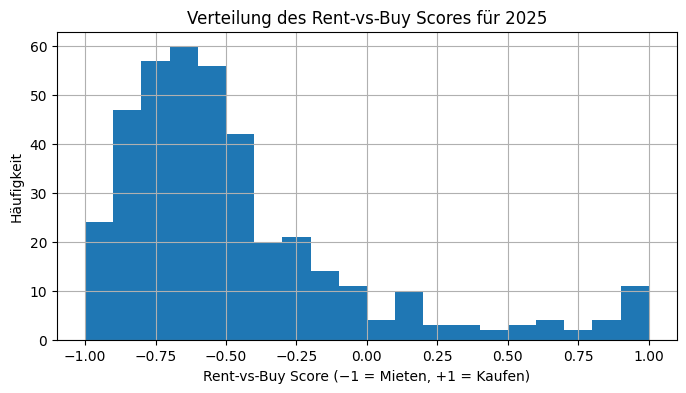

In [8]:
for year in sorted(df_empirica_regio["Jahr"].dropna().unique()):
    s = df_empirica_regio.loc[df_empirica_regio["Jahr"] == year, "Score (95% Perzentil)"].dropna()
    if s.empty:
        continue

    plt.figure(figsize=(8, 4))
    plt.hist(s, bins=20, range=(-1, 1))
    plt.xlabel("Rent-vs-Buy Score (−1 = Mieten, +1 = Kaufen)")
    plt.ylabel("Häufigkeit")
    plt.title(f"Verteilung des Rent-vs-Buy Scores für {int(year)}")
    plt.grid(True)
    plt.show()